In [1]:
# Import packages
import sys
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import tqdm

import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from IPython.display import clear_output
from IPython import display

%matplotlib inline

# check and use GPU if available if not use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.distributions import MultivariateNormal


In [2]:
class ContinuousPolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, layers=[32,32,16]):
        super().__init__()

        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        # Output layer for mean
        self.mean_layer = torch.nn.Linear(layers[2], output_size)
        
        # Output layer for log(std_dev), which is more numerically stable
        self.log_stddev_layer = torch.nn.Linear(layers[2], output_size)

        # Initialization using Xavier normal
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)

        torch.nn.init.xavier_normal_(self.mean_layer.weight)
        torch.nn.init.xavier_normal_(self.log_stddev_layer.weight)

    def forward(self, inputs):
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        
        mean = self.mean_layer(x)
        log_stddev = self.log_stddev_layer(x)
        return mean, log_stddev


In [8]:
# CODE from another notebook
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        # Define layers with ReLU activation
        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        # Initialization using Xavier normal (a popular technique for initializing weights in NNs)
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        #test if inputs is NaN
        if torch.isnan(inputs).any():
            print("inputs is NaN=",inputs)

        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x


def generate_single_episode(env, policy_net):
    """
    Generates an episode by executing the current policy in the given env
    """
    states = []
    actions = []
    rewards = []
    log_probs = []
    max_t = 1000 # max horizon within one episode
    state, _ = env.reset()

    # if isinstance(env.action_space, gym.spaces.Box):
    #     max_possible_action = float(env.action_space.high[0]) # Only works with a action space dim of 1
    #     min_possible_action = float(env.action_space.low[0]) # Only works with a action space dim of 1
    #     max_possible_variance = max_possible_action - min_possible_action
    #     max_acceptable_variance = 0.1 * max_possible_variance

    for t in range(max_t):
        #print(t)
        state = torch.from_numpy(state).float().unsqueeze(0)
        #test if state is NaN
        if torch.isnan(state).any():
            print("state is NaN=",state)
            
        # if action space is discrete or continuous
        if isinstance(env.action_space, gym.spaces.Discrete):
            probs = policy_net.forward(Variable(state)) # get each action choice probability with the current policy network
            action = np.random.choice(env.action_space.n, p=np.squeeze(probs.detach().numpy())) # probablistic
        else:
            mean, log_stddev = policy_net.forward(Variable(state))
            #test if mean and log_stddev is NaN
            if torch.isnan(mean).any():
                print("mean P is NaN=",mean)

            if torch.isnan(log_stddev).any():
                print("log_stddev P is NaN=",log_stddev)

            stddev = torch.clamp(torch.exp(log_stddev), min=0.01, max=1.0)
            dist = torch.distributions.Normal(mean, stddev)
            action = dist.sample()[0]
            #print("action=",action)

            # HERE BEFORE CHATGPT
            # probs = policy_net.forward(Variable(state))
            # #check if probs is NaN
            # if torch.isnan(probs).any():
            #     print("probs is NaN=",probs)
            #     probs = torch.zeros(probs.shape)
            #     probs[0][0] = 0

            # cov_mat = torch.eye(env.action_space.shape[0]) * 1  # Adjust covariance matrix dynamically or learn it

            # dist = MultivariateNormal(probs, cov_mat)
            # action = dist.sample().detach().numpy()[0][0]   # Only works with a action space dim of 1
            # #check if action is within the action space
            # if action < min_possible_action:
            #     action = min_possible_action
            # elif action > max_possible_action:
            #     action = max_possible_action
            # HERE BEFORE CHATGPT
            

        # action = np.argmax(probs.detach().numpy()) # greedy

        #print("action=",action)

        # compute the log_prob to use this in parameter update
        log_prob = None
        if isinstance(env.action_space, gym.spaces.Discrete):
            log_prob = torch.log(probs.squeeze(0)[action])
        else:
            #log_prob = dist.log_prob(torch.tensor([action]))
            log_prob = dist.log_prob(action).sum(dim=-1)  # Sum over action dimensions

            
        #print(log_prob)
        
        # append values
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        
        # take a selected action
        if isinstance(env.action_space, gym.spaces.Discrete):
            state, reward, terminated, truncated, _ = env.step(action)
        else:
            state, reward, terminated, truncated, _ = env.step(action)
            #state, reward, terminated, truncated, _ = env.step([action])

        rewards.append(reward)

        if terminated | truncated:
            break
            
    return states, actions, rewards, log_probs


def evaluate_policy(env, policy_net):
    """
    Compute accumulative trajectory reward
    """
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    return np.sum(rewards)

In [25]:
def train_PPO(env, policy_net, policy_optimizer, value_net, value_optimizer, num_epochs, clip_val=0.2, gamma=0.99):
    """
    Trains the policy network using PPO
    """
    # Generate an episode with the current policy network
    states, actions, rewards, log_probs = generate_single_episode(env, policy_net)
    T = len(states)

    # Create tensors depending on if it is discrete or continuous action space
    if isinstance(env.action_space, gym.spaces.Discrete):
        actions = torch.LongTensor(actions).to(device).view(-1,1)
    else:
        actions = torch.FloatTensor(actions).to(device).view(-1,1)


    states = np.vstack(states).astype(float)
    states = torch.FloatTensor(states).to(device)
    #actions = torch.LongTensor(actions).to(device).view(-1,1)
    rewards = torch.FloatTensor(rewards).to(device).view(-1,1)
    log_probs = torch.FloatTensor(log_probs).to(device).view(-1,1)

    # Compute total discounted return at each time step
    Gs = []
    G = 0
    for t in range(T-1,-1,-1): # iterate in backward order to make the computation easier
        G = rewards[t] + gamma*G
        Gs.insert(0,G)
    Gs = torch.tensor(Gs).view(-1,1)
    
    # Compute the advantage
    state_vals = value_net(states).to(device)
    with torch.no_grad():
        A_k = Gs - state_vals
        
    for j in range(num_epochs):
        #print("states V=",states)
        V = value_net(states).to(device)  
        if torch.isnan(V).any():
            print("V is NaN=", V) 
        # compute the log_prob to use it in parameter update
        if isinstance(env.action_space, gym.spaces.Discrete):
            # Calculate probability of each action under the updated policy
            probs = policy_net.forward(states).to(device)
            curr_log_probs = torch.log(torch.gather(probs, 1, actions)) # Use torch.gather(A,1,B) to select columns from A based on indices in B
        else:
            # Calculate log probability of the sampled action
            mean, log_stddev = policy_net.forward(states)

            

            #test if mean and log_stddev is NaN
            if torch.isnan(mean).any():
                print("Epoch=",j)
                print("mean V is NaN=",mean)
            if torch.isnan(log_stddev).any():
                print("log_stddev V is NaN=",log_stddev)

            stddev = torch.clamp(torch.exp(log_stddev), min=0.01, max=1.0)
            dist = torch.distributions.Normal(mean, stddev)
            curr_log_probs = dist.log_prob(actions).sum(dim=-1)  # Sum over action dimensions
            #print("curr_log_probs=",curr_log_probs)
            #curr_log_probs = torch.log(probs)
        
        # Calculate ratios r(theta)
        ratios = torch.exp(curr_log_probs - log_probs)
        
        # Calculate two surrogate loss terms in cliped loss
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1-clip_val, 1+clip_val) * A_k
        
        # Calculate clipped loss value
        actor_loss = (-torch.min(surr1, surr2)).mean() # Need negative sign to run Gradient Ascent

        # Update policy network
        policy_optimizer.zero_grad()
        actor_loss.backward(retain_graph=True)

        torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 100) # Clip gradients to prevent exploding gradients (100 is an arbitrary value)
        policy_optimizer.step()
        
        # Update value net
        critic_loss = nn.MSELoss()(V, Gs)
        value_optimizer.zero_grad()
        critic_loss.backward()
        value_optimizer.step()
        
    return policy_net, value_net

  0%|          | 0/1 [00:00<?, ?it/s]

Episode: 0
The avg. test reward for episode 0 is 22.5 with std of 11.672617529928752.
Episode: 50
The avg. test reward for episode 50 is 9.35 with std of 0.7262919523166975.
Episode: 100
The avg. test reward for episode 100 is 21.1 with std of 4.559605246071199.
Episode: 150
The avg. test reward for episode 150 is 196.5 with std of 6.2008063991709985.
Episode: 200
The avg. test reward for episode 200 is 192.85 with std of 9.540833296940054.
Episode: 250
The avg. test reward for episode 250 is 185.15 with std of 21.43425995923349.
Episode: 300
The avg. test reward for episode 300 is 155.8 with std of 13.655035701161678.
Episode: 350
The avg. test reward for episode 350 is 196.25 with std of 16.345871038277526.
Episode: 400
The avg. test reward for episode 400 is 195.9 with std of 17.871485668516765.
Episode: 450
The avg. test reward for episode 450 is 200.0 with std of 0.0.
Episode: 500
The avg. test reward for episode 500 is 200.0 with std of 0.0.
Episode: 550
The avg. test reward for 

100%|██████████| 1/1 [02:28<00:00, 148.92s/it]


Text(0.5, 1.0, 'PPO Learning Curve')

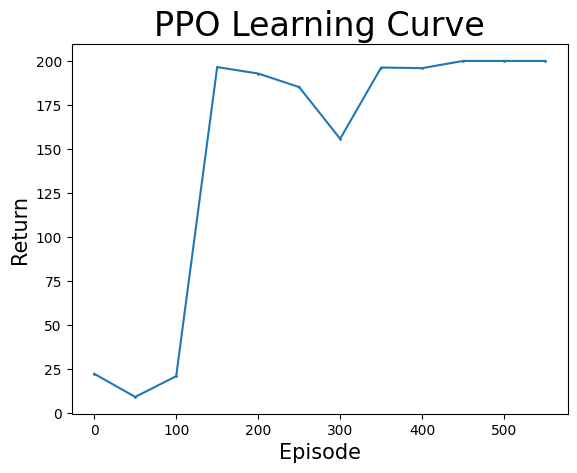

In [41]:
# Define parameter values
env_name = 'CartPole-v0' # environment name
#env_name = 'CartPole-v1' # environment name
#env_name = 'Pendulum-v1' # environment name

#env_name = 'LunarLander-v2' # environment name
#env_name = 'MountainCar-v0' # environment name
#env_name = 'Acrobot-v1' # environment name


num_train_ite = 600 # number of training iterations
num_seeds = 1 # fit model with 3 different seeds and plot average performance of 3 seeds
num_epochs = 10 # how many times we iterate the entire training dataset passing through the training
eval_freq = 50 # run evaluation of policy at each eval_freq trials
eval_epi_index = num_train_ite//eval_freq # use to create x label for plot
returns = np.zeros((num_seeds, eval_epi_index))
gamma = 0.99 # discount factor
clip_val = 0.2 # hyperparameter epsilon in clip objective

# Create the environment.
env = gym.make(env_name)

#detect if the environment is discrete or continuous
if isinstance(env.action_space, gym.spaces.Discrete):
    nA = env.action_space.n
else:
    nA = env.action_space.shape[0]

# detect if the environment state is discrete or continuous
if isinstance(env.observation_space, gym.spaces.Discrete):
    nS = env.observation_space.n
else:
    nS = env.observation_space.shape[0]

policy_lr = 5e-4 # policy network's learning rate 
baseline_lr = 1e-4 # value network's learning rate
 
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Define policy and value networks
    if isinstance(env.action_space, gym.spaces.Discrete):
        policy_net = NeuralNet(nS, nA, torch.nn.Softmax()) # Normally this one works with CartPole-v0
    else:
        #policy_net = NeuralNet(nS, nA, torch.nn.Identity())
        policy_net = ContinuousPolicyNet(nS, nA)
        
    policy_net_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_net = NeuralNet(nS, 1, torch.nn.ReLU())
    value_net_optimizer = optim.Adam(value_net.parameters(), lr=baseline_lr)
    
    for m in range(num_train_ite):
        # Train networks with PPO
        policy_net, value_net = train_PPO(env, policy_net, policy_net_optimizer, value_net, value_net_optimizer, num_epochs, clip_val=clip_val, gamma=gamma)
        if m % eval_freq == 0:
            print("Episode: {}".format(m))
            G = np.zeros(20)
            for k in range(20):
                g = evaluate_policy(env, policy_net)
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print("The avg. test reward for episode {0} is {1} with std of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
    returns[i] = np.array(reward_means)


# Plot the performance over iterations
x = np.arange(eval_epi_index)*eval_freq
avg_returns = np.mean(returns, axis=0)
max_returns = np.max(returns, axis=0)
min_returns = np.min(returns, axis=0)

plt.fill_between(x, min_returns, max_returns, alpha=0.1)
plt.plot(x, avg_returns, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

plt.title("PPO Learning Curve", fontsize = 24)